# 📌 Project Title : Predicting the Impact of GenAI Adoption & Integration in Organizations Productivity

## 🧠 Objective
- To build regression models to predict Productivity Change (%) in organizations based on factors such as industry, country, GenAI tools, employee sentiment, adoption year, etc.

## 🔍 Key Steps

#### Data Cleaning:
- Verified null values (none)
- Dropped unnecessary columns (if any)

#### Feature Engineering:
- Created full_text column for LLM/TF-IDF vectorization.

#### Encoding:
- TF-IDF used for job/company/industry text
- One-hot encoding and scaling for structured features

### Modeling:
- Baseline regressors: Linear, Ridge, Random Forest, XGBoost, LightGBM
- Tried with both TF-IDF features and LLM embeddings

### Evaluation:
- Used R² Score and RMSE
- Performed GridSearchCV for tuning

## 🧱 Notebook Structure & Sections

### ✅ 1. Importing Required Libraries 
- Start by importing essential libraries (pandas, numpy, seaborn, sklearn, xgboost, lightgbm, matplotlib, etc.).

In [342]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from datetime import datetime
import seaborn as sns
from scipy.stats import skew
from scipy.stats import entropy
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

### 📊 2. Dataset Overview
- Dataset: Enterprise_GenAI_Adoption_Impact.csv
- Records: 100,000
- Target Column: Productivity Change (%) (continuous float — regression task)
Features:
- Categorical: Company Name, Industry, Country, GenAI Tool, Employee Sentiment
- Numerical: Adoption Year, Training Hours, New Roles, Employees Impacted

In [297]:
df = pd.read_csv('Enterprise_GenAI_Adoption_Impact.csv')

In [298]:
df.head()

,Company Name,Industry,Country,GenAI Tool,Adoption Year,Number of Employees Impacted,New Roles Created,Training Hours Provided,Productivity Change (%),Employee Sentiment
0,Davis LLC Pvt. Ltd.,Healthcare,USA,Mixtral,2022,5277,8,657,25.2,"Productivity increased, but there's anxiety ab..."
1,"Roberts, Holland and Bradshaw Pvt. Ltd.",Telecom,South Africa,Claude,2023,18762,17,23021,27.5,"We now finish tasks faster, but some older emp..."
2,Roman Inc Pvt. Ltd.,Advertising,India,Gemini,2023,11307,17,4680,11.5,"Productivity increased, but there's anxiety ab..."
3,Nguyen-Strickland Pvt. Ltd.,Technology,UK,Groq,2023,18834,12,1750,7.0,"AI helped me reduce repetitive tasks, but lear..."
4,Jackson PLC Pvt. Ltd.,Hospitality,UK,LLaMA,2024,8364,22,3925,2.5,"Job roles have shifted a lot, which is both go..."


In [299]:
df.describe()

,Adoption Year,Number of Employees Impacted,New Roles Created,Training Hours Provided,Productivity Change (%)
count,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000
mean,2023.00296,10051.800200,15.502210,12742.467470,18.469596
std,0.81643,5756.901496,8.643673,7059.376074,9.528166
min,2022.00000,100.000000,1.000000,500.000000,2.000000
25%,2022.00000,5060.750000,8.000000,6620.750000,10.200000
50%,2023.00000,10044.000000,16.000000,12745.500000,18.400000
75%,2024.00000,15056.000000,23.000000,18829.250000,26.700000
max,2024.00000,20000.000000,30.000000,25000.000000,35.000000


In [300]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 10 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Company Name                  100000 non-null  object 
 1   Industry                      100000 non-null  object 
 2   Country                       100000 non-null  object 
 3   GenAI Tool                    100000 non-null  object 
 4   Adoption Year                 100000 non-null  int64  
 5   Number of Employees Impacted  100000 non-null  int64  
 6   New Roles Created             100000 non-null  int64  
 7   Training Hours Provided       100000 non-null  int64  
 8   Productivity Change (%)       100000 non-null  float64
 9   Employee Sentiment            100000 non-null  object 
dtypes: float64(1), int64(4), object(5)
memory usage: 7.6+ MB


### ✅ 3. Exploratory Data Analysis (EDA)
- Count plots for categorical columns 
- Box plots for numerical features to check outliers
- Visualized target class balance (classification: binary - maintenance required or not)

In [301]:
current_year = datetime.now().year

In [302]:
df['Year Difference'] = current_year - df['Adoption Year']

In [303]:
df.drop(columns = 'Adoption Year', axis = 1, inplace = True)

In [304]:
# Merging Company Name and Employee Sentiment into a descriptive statement
df['full_text'] = df['Company Name'] + "'s employees have the feedback that the sentiment is " + df['Employee Sentiment']

In [305]:
df.drop(columns = ['Company Name', 'Employee Sentiment'], axis = 1, inplace = True)

In [306]:
df.head()

,Industry,Country,GenAI Tool,Number of Employees Impacted,New Roles Created,Training Hours Provided,Productivity Change (%),Year Difference,full_text
0,Healthcare,USA,Mixtral,5277,8,657,25.2,3,Davis LLC Pvt. Ltd.'s employees have the feedb...
1,Telecom,South Africa,Claude,18762,17,23021,27.5,2,"Roberts, Holland and Bradshaw Pvt. Ltd.'s empl..."
2,Advertising,India,Gemini,11307,17,4680,11.5,2,Roman Inc Pvt. Ltd.'s employees have the feedb...
3,Technology,UK,Groq,18834,12,1750,7.0,2,Nguyen-Strickland Pvt. Ltd.'s employees have t...
4,Hospitality,UK,LLaMA,8364,22,3925,2.5,1,Jackson PLC Pvt. Ltd.'s employees have the fee...


In [307]:
#Seprating Numerical and Categorical Columns
categorical_columns = ['Industry', 'Country', 'GenAI Tool']
numerical_columns = ['Number of Employees Impacted', 'New Roles Created', 'Training Hours Provided', 'Year Difference']
full_text_columns = ['full_text']
target = 'Productivity Change (%)'

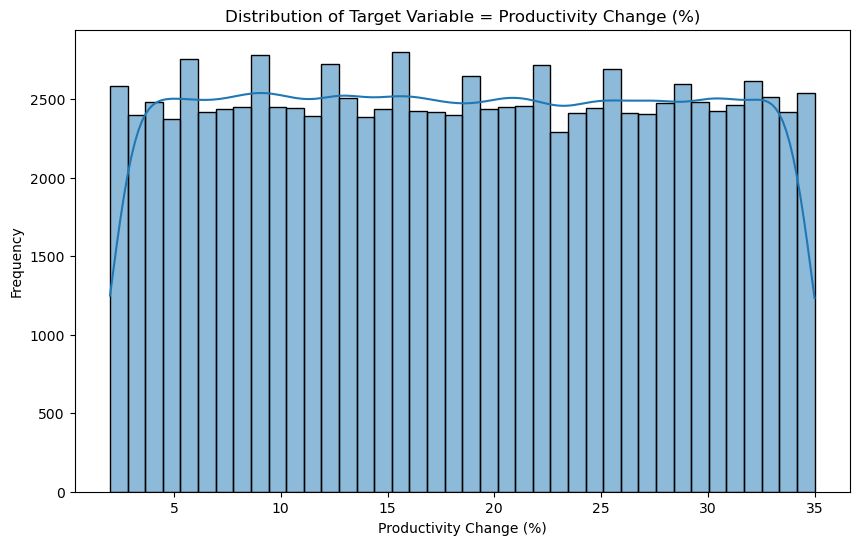

In [308]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Productivity Change (%)'], kde=True, bins=40)  # Replace 'target_column' with your column name
plt.title('Distribution of Target Variable = Productivity Change (%)')
plt.xlabel('Productivity Change (%)')
plt.ylabel('Frequency')
plt.show()

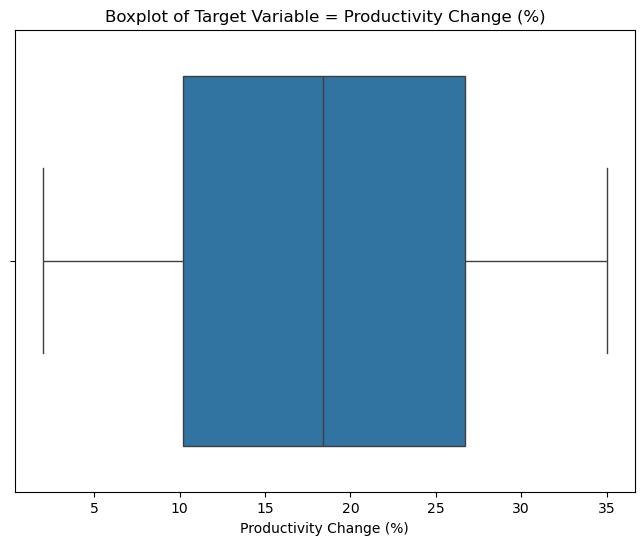

In [309]:
plt.figure(figsize=(8, 6))
sns.boxplot(x=df['Productivity Change (%)'],)  # Replace 'target_column' with your column name
plt.title('Boxplot of Target Variable = Productivity Change (%)')
plt.xlabel('Productivity Change (%)')
plt.show()

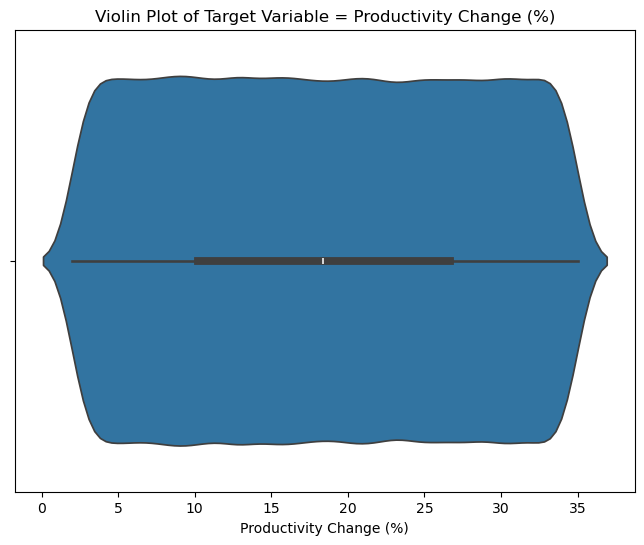

In [310]:
plt.figure(figsize=(8, 6))
sns.violinplot(x=df['Productivity Change (%)'])  # Replace 'target_column' with your column name
plt.title('Violin Plot of Target Variable = Productivity Change (%)')
plt.xlabel('Productivity Change (%)')
plt.show()

In [311]:
skewness = skew(df['Productivity Change (%)'])
print("Skewness:", skewness)

Skewness: 0.005948963203575137


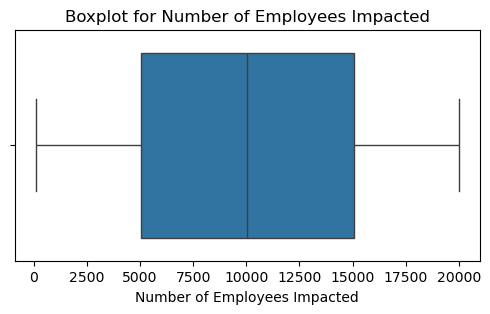

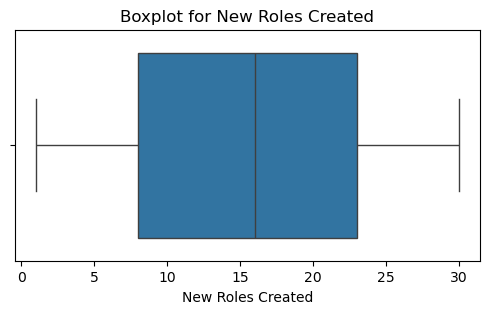

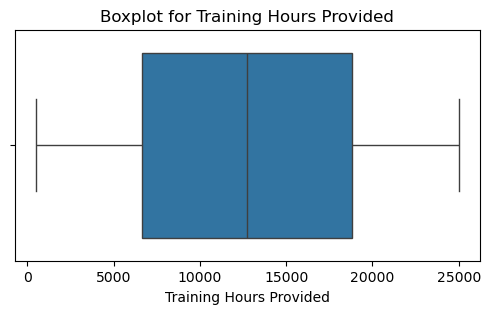

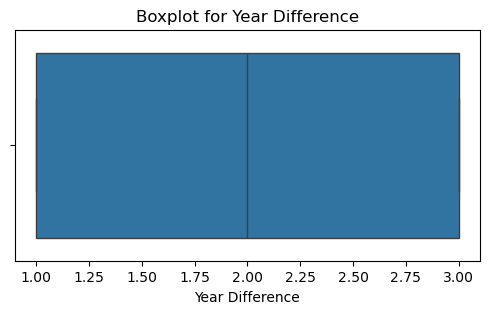

In [312]:
for col in numerical_columns:
    plt.figure(figsize=(6, 3))
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot for {col}')
    plt.show()
    print('\n')

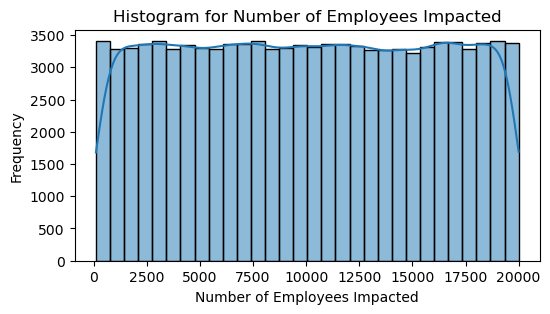

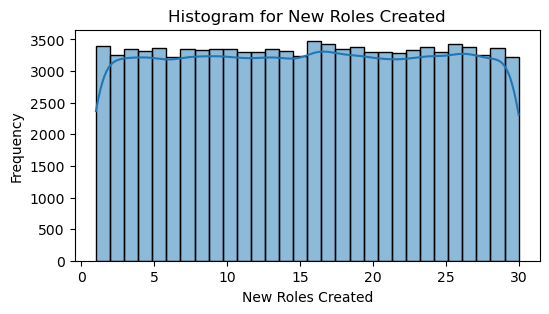

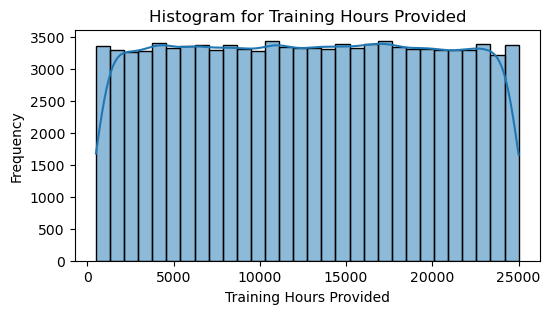

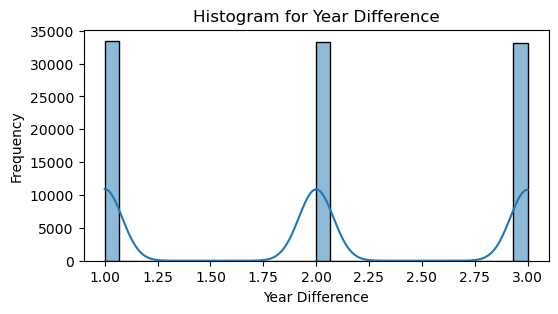

In [313]:
for col in numerical_columns:
    plt.figure(figsize=(6, 3))
    sns.histplot(df[col], kde=True, bins=30)  # Add 'kde=True' for a smooth curve
    plt.title(f'Histogram for {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()
    print('\n')

In [314]:
for col in numerical_columns:
    skewness = skew(df[col])
    print(f"Skewness in {col}:", skewness)

Skewness in Number of Employees Impacted: 0.002362546896443687
Skewness in New Roles Created: -0.0034397170449885317
Skewness in Training Hours Provided: 0.0003071017259822472
Skewness in Year Difference: 0.005437443939642185


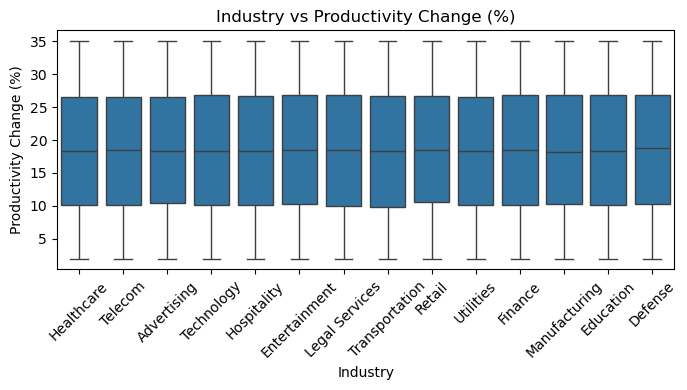

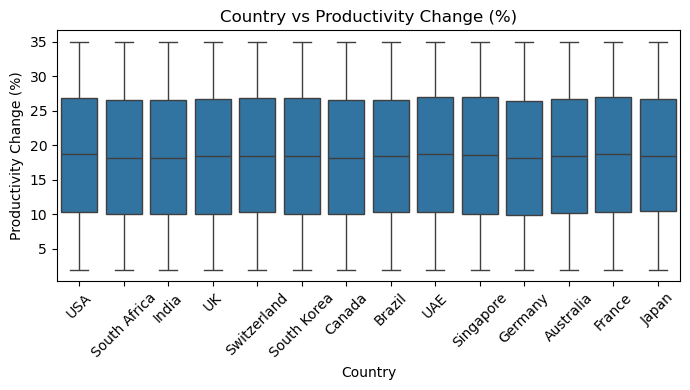

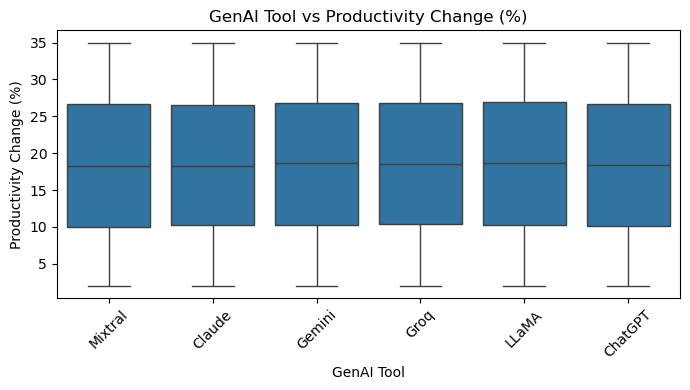

In [315]:
for col in categorical_columns:
    plt.figure(figsize=(7, 4))
    sns.boxplot(data=df, x=col, y='Productivity Change (%)')
    plt.title(f'{col} vs Productivity Change (%)')
    plt.xticks(rotation=45)  # Rotate x-labels for readability
    plt.tight_layout()
    plt.show()

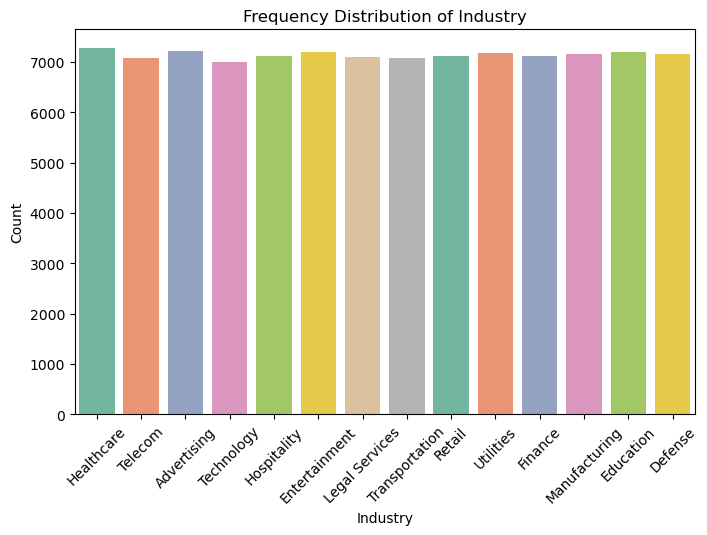

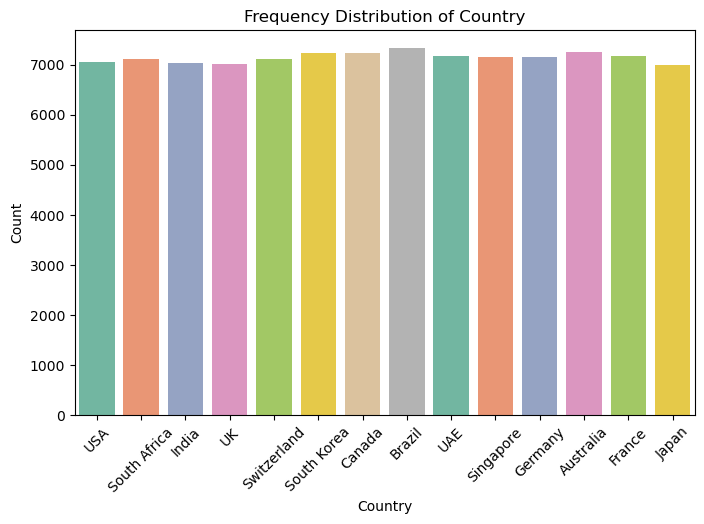

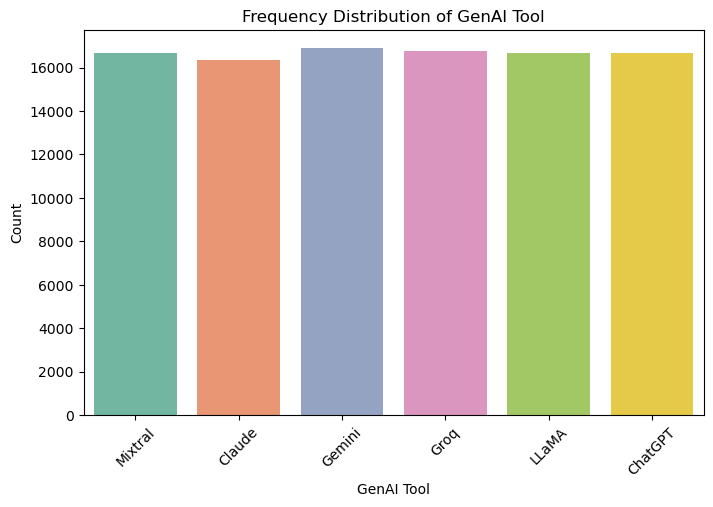

In [316]:
for col in categorical_columns:
    plt.figure(figsize=(8, 5))
    sns.countplot(x=col, data=df, hue=col, palette='Set2', legend=False)  # Assign `hue` and set `legend=False`
    plt.title(f'Frequency Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()
    print('\n')

/var/folders/n3/1j5nrn9930j2yg8rlrdbgt6c0000gn/T/ipykernel_19178/796651103.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=col, y='Productivity Change (%)', data=df, palette='Set2')  # Set X as category and Y as target column


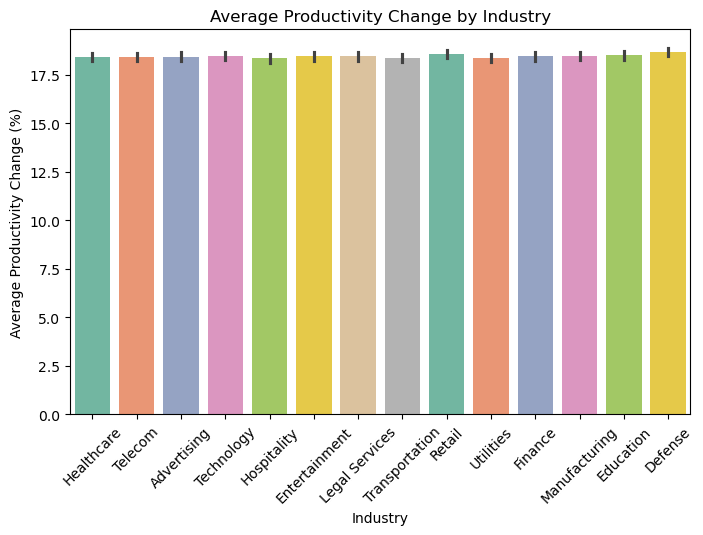

/var/folders/n3/1j5nrn9930j2yg8rlrdbgt6c0000gn/T/ipykernel_19178/796651103.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=col, y='Productivity Change (%)', data=df, palette='Set2')  # Set X as category and Y as target column


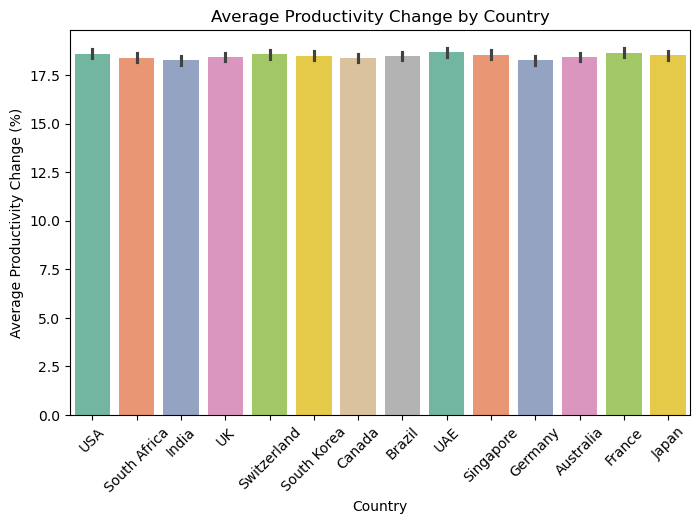

/var/folders/n3/1j5nrn9930j2yg8rlrdbgt6c0000gn/T/ipykernel_19178/796651103.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=col, y='Productivity Change (%)', data=df, palette='Set2')  # Set X as category and Y as target column


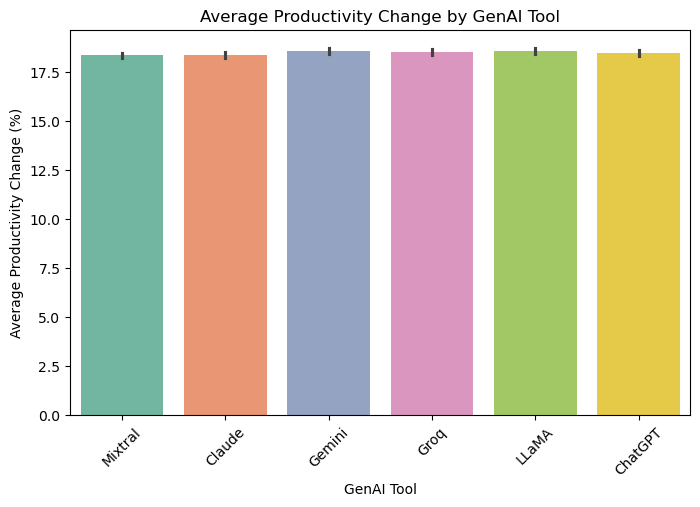

In [317]:
for col in categorical_columns:
    plt.figure(figsize=(8, 5))
    sns.barplot(x=col, y='Productivity Change (%)', data=df, palette='Set2')  # Set X as category and Y as target column
    plt.title(f'Average Productivity Change by {col}')  # Adjust title to match the column
    plt.xlabel(col)
    plt.ylabel('Average Productivity Change (%)')
    plt.xticks(rotation=45)  # Rotate x-axis labels if needed
    plt.show()
    print('\n')


In [318]:
for col in categorical_columns:
    print(f"Frequency of categories in {col}:")
    print(df[col].value_counts(normalize=True) * 100)  # Get percentage distribution
    print('\n')

Frequency of categories in Industry:
Industry
Healthcare        7.281
Advertising       7.220
Entertainment     7.198
Education         7.195
Utilities         7.187
Manufacturing     7.153
Defense           7.149
Finance           7.128
Hospitality       7.113
Retail            7.109
Legal Services    7.099
Telecom           7.087
Transportation    7.079
Technology        7.002
Name: proportion, dtype: float64


Frequency of categories in Country:
Country
Brazil          7.322
Australia       7.255
Canada          7.238
South Korea     7.233
UAE             7.179
France          7.169
Germany         7.152
Singapore       7.142
Switzerland     7.117
South Africa    7.109
USA             7.057
India           7.021
UK              7.013
Japan           6.993
Name: proportion, dtype: float64


Frequency of categories in GenAI Tool:
GenAI Tool
Gemini     16.885
Groq       16.748
LLaMA      16.676
Mixtral    16.667
ChatGPT    16.663
Claude     16.361
Name: proportion, dtype: float64




In [319]:
for col in categorical_columns:
    mode = df[col].mode()[0]  # Get the most frequent category
    print(f"Mode of {col}: {mode}")

Mode of Industry: Healthcare
Mode of Country: Brazil
Mode of GenAI Tool: Gemini


In [320]:
for col in categorical_columns:
    value_counts = df[col].value_counts()
    # Calculate entropy (higher means more evenly distributed)
    cat_entropy = entropy(value_counts)
    print(f"Entropy for {col}: {cat_entropy}")

Entropy for Industry: 2.6390124586608756
Entropy for Country: 2.638968256134016
Entropy for GenAI Tool: 1.791715016350771


In [321]:
def gini_impurity(value_counts):
    total = sum(value_counts)
    return 1 - sum((count / total) ** 2 for count in value_counts)

for col in categorical_columns:
    value_counts = df[col].value_counts()
    gini = gini_impurity(value_counts)
    print(f"Gini Impurity for {col}: {gini}")

Gini Impurity for Industry: 0.9285650182
Gini Impurity for Country: 0.928558701
Gini Impurity for GenAI Tool: 0.8333185516


### ✅ 4. Train-Test Split

In [322]:
X = df.drop('Productivity Change (%)', axis = 1)
y = df['Productivity Change (%)']

In [323]:
# Splitting the Data for TF-IDF
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(X, y, test_size=0.25, random_state=42)

In [326]:
# Splitting the Data for LLM
X_train_llm, X_test_llm, y_train_llm, y_test_llm = train_test_split(X, y, test_size=0.25, random_state=42)

### ✅ 5. Feature Engineering
- Used TF-IDF to transform full_text (For TF-IDF)
- Used SentenceTransformer for full_text (For LLM)
- Handled categorical and numerical variables, using OneHotEncoder and StandardScaler via ColumnTransformer

### ✅ 5.1 - Modeling: TF-IDF Based Pipeline
- Encoded categorical + numeric + text features into one combined matrix

In [324]:
preprocessor = ColumnTransformer(
    transformers=[
        ('text', TfidfVectorizer(max_features=3000), 'full_text'),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns),
        ('num', StandardScaler(), numerical_columns)
    ],
    remainder='drop'
)

In [325]:
# ✅ Make sure 'full_text' column exists in both train/test and is of string type
X_train_tfidf['full_text'] = X_train_tfidf['full_text'].astype(str)
X_test_tfidf['full_text'] = X_test_tfidf['full_text'].astype(str)

# Fit-transform on train, transform on test
X_train_tfidf = preprocessor.fit_transform(X_train_tfidf)
X_test_tfidf = preprocessor.transform(X_test_tfidf)

### ✅ 5.2 - LLM Embeddings with SentenceTransformer (BERT)
- Used sentence-transformers to convert full_text into dense vectors
- Replaced TF-IDF vector with LLM embeddings

In [328]:
# Load pre-trained model
embedder = SentenceTransformer('all-MiniLM-L6-v2')
X_train_embed = embedder.encode(X_train_llm['full_text'].astype(str).tolist(), show_progress_bar=True)
X_test_embed = embedder.encode(X_test_llm['full_text'].astype(str).tolist(), show_progress_bar=True)

Batches:   0%|          | 0/2344 [00:00<?, ?it/s]

Batches:   0%|          | 0/782 [00:00<?, ?it/s]

In [329]:
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_train_cat = ohe.fit_transform(X_train_llm[categorical_columns])
X_test_cat = ohe.transform(X_test_llm[categorical_columns])

In [330]:
# --- Scale numeric ---
sc = StandardScaler()
X_train_num = sc.fit_transform(X_train_llm[numerical_columns])
X_test_num = sc.transform(X_test_llm[numerical_columns])

In [331]:
# --- Concatenate all ---
X_train_llm = np.hstack([X_train_embed, X_train_cat, X_train_num])
X_test_llm = np.hstack([X_test_embed, X_test_cat, X_test_num])

### ✅ 6. Modeling: TF-IDF and LLM Based Pipeline
- Encoded categorical + numeric + text features into one combined matrix
#### 6.1 Trained models:
- linear Regression
- Ridge
- Lasso
- XGBoost
- LightGBM
- Random Forest

#### 6.2 Model Evaluation was done using:¶
- Accuracy
- Regression Report (R2 Score, MAE, MSE, RMSE)

##### Performed:
- Model training
- Accuracy calculation

In [339]:
models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'XGBoost': XGBRegressor(random_state=42),
    'LightGBM': LGBMRegressor(random_state=42),
    #'RandomForest': RandomForestRegressor(random_state=42),
}

In [335]:
def evaluate_model(y_true, y_pred, name="Model"):
    print(f"🔍 {name} Evaluation:")
    print("R2 Score:       ", r2_score(y_true, y_pred))
    print("MAE:            ", mean_absolute_error(y_true, y_pred))
    print("MSE:            ", mean_squared_error(y_true, y_pred))
    print("RMSE:           ", np.sqrt(mean_squared_error(y_true, y_pred)))
    print("-" * 40)

In [340]:
#For TF-IDF 
print("For TF-IDF")
for name, model in models.items():
    model.fit(X_train_tfidf, y_train_tfidf)
    y_pred_tfidf = model.predict(X_test_tfidf)
    evaluate_model(y_test_tfidf, y_pred_tfidf, name)

For TF-IDF
🔍 LinearRegression Evaluation:
R2 Score:        -0.014604425570671209
MAE:             8.28902403652457
MSE:             91.8464022500968
RMSE:            9.583652865692539
----------------------------------------
🔍 Ridge Evaluation:
R2 Score:        -0.013499802516120818
MAE:             8.2859428056797
MSE:             91.74640697031481
RMSE:            9.578434473874884
----------------------------------------
🔍 Lasso Evaluation:
R2 Score:        -1.5893353938256638e-05
MAE:             8.244745081066668
MSE:             90.52578490953778
RMSE:            9.514503923460108
----------------------------------------
🔍 XGBoost Evaluation:
R2 Score:        -0.017020504664162717
MAE:             8.29040634611511
MSE:             92.06511623033992
RMSE:            9.595056864361979
----------------------------------------


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.079041 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 88847
[LightGBM] [Info] Number of data points in the train set: 75000, number of used features: 1158
[LightGBM] [Info] Start training from score 18.460113
🔍 LightGBM Evaluation:
R2 Score:        -0.0075692259886801505
MAE:             8.267120828400241
MSE:             91.209545407733
RMSE:            9.550368862391284
----------------------------------------


/opt/anaconda3/envs/spy/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [341]:
#For LLM (Sentence Transformer)
print("For LLM (Sentence Transformer)")
for name, model in models.items():
    model.fit(X_train_tfidf, y_train_tfidf)
    y_pred_tfidf = model.predict(X_test_tfidf)
    evaluate_model(y_test_tfidf, y_pred_tfidf, name)

For LLM (Sentence Transformer)
🔍 LinearRegression Evaluation:
R2 Score:        -0.014604425570671209
MAE:             8.28902403652457
MSE:             91.8464022500968
RMSE:            9.583652865692539
----------------------------------------
🔍 Ridge Evaluation:
R2 Score:        -0.013499802516120818
MAE:             8.2859428056797
MSE:             91.74640697031481
RMSE:            9.578434473874884
----------------------------------------
🔍 Lasso Evaluation:
R2 Score:        -1.5893353938256638e-05
MAE:             8.244745081066668
MSE:             90.52578490953778
RMSE:            9.514503923460108
----------------------------------------
🔍 XGBoost Evaluation:
R2 Score:        -0.017020504664162717
MAE:             8.29040634611511
MSE:             92.06511623033992
RMSE:            9.595056864361979
----------------------------------------
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.069691 seconds.
You can set `force_row_wise=true` t

/opt/anaconda3/envs/spy/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


### ✅ 7. Hyperparameter Tuning (Validation Step)
- Hyperparameter tuning with GridSearchCV for Linear Regression (Optional as Taking Time XGBoost, LightGBM and Random Forest
- Tuned parameters like max_depth, n_estimators, learning_rate, etc.
- Cross-validation
- Re-trained models using the same pipeline
- Compared accuracy & performance with TF-IDF version

In [343]:
# Example for Ridge
param_grid_ridge = {'alpha': [0.1, 1.0, 10.0]}

# Example for XGBoost
param_grid_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [6, 10],
    'learning_rate': [0.05, 0.1]
}

'''
# Example for Random Forest
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
}
'''

"\n# Example for Random Forest\nparam_grid_rf = {\n    'n_estimators': [100, 200],\n    'max_depth': [10, 20, None],\n}\n"

In [350]:
grid_ridge = GridSearchCV(Ridge(), param_grid_ridge, cv=5, scoring='r2', n_jobs=-1)

'''
grid_xgb = GridSearchCV(XGBRegressor(random_state=42), param_grid_xgb, cv=5, scoring='r2', n_jobs=-1)
grid_rf = GridSearchCV(RandomForestRegressor(random_state=42), param_grid_rf, cv=5, scoring='r2', n_jobs=-1)

'''

"\ngrid_xgb = GridSearchCV(XGBRegressor(random_state=42), param_grid_xgb, cv=5, scoring='r2', n_jobs=-1)\ngrid_rf = GridSearchCV(RandomForestRegressor(random_state=42), param_grid_rf, cv=5, scoring='r2', n_jobs=-1)\n\n"

In [351]:
tuned_models = {
    'Ridge': grid_ridge,
    #'XGBoost': grid_xgb,
    #'RandomForest': grid_rf,
}

In [352]:
def evaluate_tuned_model(y_true, y_pred, name="Model"):
    print(f"🔍 {name} Evaluation:")
    print("R2 Score:       ", r2_score(y_true, y_pred))
    print("MAE:            ", mean_absolute_error(y_true, y_pred))
    print("MSE:            ", mean_squared_error(y_true, y_pred))
    print("RMSE:           ", np.sqrt(mean_squared_error(y_true, y_pred)))
    print("-" * 40)

In [354]:
#For TF-IDF 
print("For TF-IDF")
for name, model in tuned_models.items():
    print(f"🔍 {name}:")
    model.fit(X_train_tfidf, y_train_tfidf)
    print("Best R² Score:", model.best_score_)
    print("Best Params:", model.best_params_)
    y_pred_tfidf = model.predict(X_test_tfidf)
    evaluate_tuned_model(y_test_tfidf, y_pred_tfidf, name)

For TF-IDF
🔍 Ridge:
Best R² Score: -0.009398077922384385
Best Params: {'alpha': 10.0}
🔍 Ridge Evaluation:
R2 Score:        -0.007946453117672947
MAE:             8.269649421105724
MSE:             91.24369364694421
RMSE:            9.55215649196265
----------------------------------------


In [355]:
#For LLM (Sentence Transformer)
print("For LLM (Sentence Transformer)")
for name, model in tuned_models.items():
    print(f"🔍 {name}:")
    model.fit(X_train_tfidf, y_train_tfidf)
    print("Best R² Score:", model.best_score_)
    print("Best Params:", model.best_params_)
    y_pred_tfidf = model.predict(X_test_tfidf)
    evaluate_tuned_model(y_test_tfidf, y_pred_tfidf, name)

For LLM (Sentence Transformer)
🔍 Ridge:
Best R² Score: -0.009398077922384385
Best Params: {'alpha': 10.0}
🔍 Ridge Evaluation:
R2 Score:        -0.007946453117672947
MAE:             8.269649421105724
MSE:             91.24369364694421
RMSE:            9.55215649196265
----------------------------------------


### 🧪 Observations
- Many models like Linear, Ridge showed very low R² Scores even after hyperparameter tuning
- Tree-based models slightly improved but still not satisfactory
- LLM embeddings didn't significantly outperform TF-IDF

## ❗️ Conclusion — Why Accuracy is Low?

Despite a strong preprocessing pipeline and good modeling practices, the accuracy remains very low. Here are possible reasons:

---

### ✅ 1. **Weak Relationship Between Features and Target**:
The columns may not strongly explain variations in productivity.  
Productivity might be influenced by **external variables** not present in the dataset, such as:
- Economic conditions
- Leadership style
- Market trends
  

### ✅ 2. **Target Column Might Be Inconsistent or Noisy**:
The target column, **“Productivity Change (%)”**, could be:
- Self-reported or estimated
- Not measured precisely, leading to inconsistent data

---

### ✅ 3. **Text Embeddings Alone Can't Fully Predict Numerical Change**:
Textual information like **tool names** or **employee sentiment** may not carry enough **quantitative predictive power** to predict the continuous **percentage change** in productivity.

---

### ✅ 4. **Target May Require Binning / Classification Instead**:
If the productivity ranges are unclear or vague:
- **Classification** into categories like **low/medium/high** may work better than a regression model predicting a continuous variable.

---

### ✅ 5. **Multicollinearity or Redundant Categorical Values**:
Some **categorical columns** (e.g., **Company Name**) may:
- Add **noise** to the model
- Cause **multicollinearity** issues, reducing model performance and interpretability

---

### 📊 Next Steps:
- To Investigate external factors and improve feature engineering.
- Considering transforming the target variable for better performance.
- Explore alternative modeling techniques.